## Домашнее задание №7
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Авторы: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), Горохов Олег

Ваша основная задача: научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# Не меняйте блок кода ниже! Здесь указаны все необходимые import-ы
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [2]:
# Не меняйте блок кода ниже! 
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt -O ./onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text]) # Убираем лишние символы табуляций, приводим все буквы к нижнему регистру
# __________end of block__________

--2023-04-13 21:01:34--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘./onegin.txt’

./onegin.txt        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-04-13 21:01:35 (9.10 MB/s) - ‘./onegin.txt’ saved [262521/262521]



Выведем несколько первых символов входного текста. Видим, что символы табуляций удалены, буквы приведены к нижнему регистру. Символы \n мы оставляем - чтобы научить сеть генерировать символ \n, когда нужно перейти на новую строку.

In [4]:
text[:36]

'\ni\n\n«мой дядя самых честных правил,\n'

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим технический токен `<sos>`.

In [5]:
# Не меняйте блок кода ниже!
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>'] # Строим множество всех токенов-символов и добавляем к нему служебный токен <sos>
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)} # Строим словарь с ключами-токенами и значениями-индексами в списке токенов
idx_to_token = {idx: x for idx, x in enumerate(tokens)} # Строим обратный словарь (чтобы по индексу можно было получить токен)

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятия №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [6]:
# Не меняйте код ниже
# __________start of block__________
batch_size = 256 # Размер батча. Батч - это набор последовательностей символов.
seq_length = 100 # Максимальная длина одной последовательности символов в батче
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>'] # Добавляем в начало каждой строки технический символ - для определения начального состояния сети

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1) # Случайным образом выбираем индекс начального символа в батче
    # Строим непрерывный батч.
    # Для этого выбираем в исходном тексте подпоследовательность, которая начинается с индекса start_index и имеет размер batch_size*seq_length.
    # Затем мы делим эту подпоследовательность на batch_size последовательностей размера seq_length. Это и будет батч, матрица размера batch_size*seq_length.
    # В каждой строке матрицы будут указаны индексы 
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1)) 
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [13]:
next(generate_chunk())

array([[83, 50, 56, ..., 50, 75,  5],
       [83,  1, 60, ..., 45, 58, 59],
       [83, 47, 53, ..., 59, 56, 51],
       ...,
       [83, 60, 59, ..., 45, 61, 63],
       [83, 72, 58, ..., 57,  0, 47],
       [83, 62, 77, ..., 62, 59, 46]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [69]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(self.__class__,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    
    def forward(self, input, hidden):
        input = self.encoder(input)
        output, hidden = self.gru(input, hidden)
        output = self.decoder(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.autograd.Variable(torch.zeros(self.n_layers, self.hidden_size)).to(device)

In [74]:
def train(model, criterion, optimizer, chunk):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for i in range(len(chunk)):
        input, target = chunk[i, :-1], chunk[i, 1:]

        output, hidden = model(input, hidden)
        loss += criterion(output, target)

    loss.backward()
    optimizer.step()

    return loss.data / len(chunk)

In [78]:
hidden_size = 20
learning_rate = 0.01

model = RNN(num_tokens, hidden_size, num_tokens).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

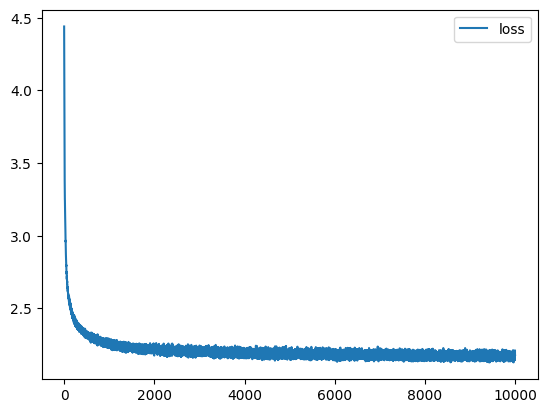

In [114]:
n_epochs = 8000
all_losses = []

for n_epoch in range(n_epochs):
    chunk = torch.tensor(next(generate_chunk())).to(device)

    loss = train(model, loss_fn, optimizer, chunk)

    all_losses.append(loss.item())

    if (n_epoch + 1) % 100 == 0:
        clear_output(True)
        plt.plot(all_losses, label='loss')
        plt.legend()
        plt.show()

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

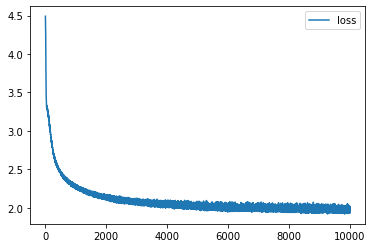

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [120]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = model.init_hidden()
    
    # #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):                                         # если длина seed_phrase > 1, то пробежимся по ней
        _, hidden = char_rnn(x_sequence[:, i], hidden)
    
    input = x_sequence[:, -1]

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        output, hidden = char_rnn(input, hidden)                                  # новое скрытое состояние и логит для след токена - это
                                                                                  # последний элемент последовательности и текущее скрытое состояние
        p_next = output.data.view(-1).div(temperature).exp()
        p_next = torch.multinomial(p_next, 1)
        next_ix = torch.tensor([[p_next[0]]], dtype=torch.int64).to(device)
        
        x_sequence = torch.cat([x_sequence, next_ix], dim=1).to(device)           # добавляем к последовательности
        
        input = x_sequence[:, -1]

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [125]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилях довутест с дремать:
так и в сетрье
имер
и гяждат.
то старенский
поло!
чотосной всё во нелько мелей шеренно шлеша всё перный и тот у кочальный перудь м наплет свитесь, уж уланной такого к были на в стразын умедивин.



xlvii

полли слемы перень чавственьез голько мыт конь петы,
и меза,
с свиденным жали их в невь мы,
в прасласкли устони дить и слеза нем, с котрав
лом в с он.
мельея на зинет любой неровы полетных он шунясь предный
что бес, ваду сечили нем без гихокл


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [116]:
generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [117]:
# do not change the code in the block below
# __________start of block__________

if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!